# Address Clustering For Yard Sign Delivery Route Optimization

The problem I set out to solve was how to best cluster addresses into predefined clusters in order to group addresses together so that delivery routes would be optimized. I had previously done this step manually by sorting by zipcodes or visualizing the data and selecting based off of drawing selections in QGIS.

In [3]:
pip install --user plotly

  Using cached https://files.pythonhosted.org/packages/5f/43/6e86a1e1910d434f068a8e032a3cc77ce862f1688776793a6735e5712fd9/plotly-5.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f2/a5/f86bc8d67c979020438c8559cc70cfe3a1643fd160d35e09c9cca6a09189/tenacity-8.0.1-py3-none-any.whl
You are using pip version 19.0.3, however version 22.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
from k_means_constrained import KMeansConstrained

ModuleNotFoundError: No module named 'pandas'

### Read the CSV

In [ ]:
df = pd.read_csv('/Users/matthewkrausse/My Drive (matt@groundgametexas.org)/Ground Game Texas/fake_delivery_data.csv')
df.head(10)

,Voter File VANID,Lat,Long
0,302815,33.142602,-97.258254
1,575048,33.144572,-97.121205
2,640440,33.214540,-97.053138
3,689001,33.227924,-97.132361
4,1025558,33.175101,-97.060067
5,1705627,33.170617,-97.131506
6,1712651,33.217498,-97.118838
7,2075916,33.181524,-97.121579
8,2342933,33.142835,-97.241081
9,2510307,33.156595,-97.128796


### Data Cleaning

All we need to do is drop NaN values and rename columns to some standardized column names for geocoding

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.rename(columns={'Lat': 'lat', 'Long': 'lng'}, inplace=True)

### Create two data frames to demonstrate Kmeans and Kmeans Constrained

In [ ]:
df2 = df

### Set Your Desired List Size

In [ ]:
desired_list_size = 15

In [ ]:
no_of_clusters = int((len(df) / desired_list_size)+2)
print(f" Number of clusters: {int(no_of_clusters)}")

 Number of clusters: 35


### First let's try Kmeans

Kmean lets us specify n_clusters which is the number of clusters that we would like to have. I initially used the length of the data / the desired list size in order to get the desired number of clusters

In [ ]:
kmeans = KMeans(n_clusters = int(no_of_clusters), 
                init ='k-means++')
kmeans.fit(df[df.columns[1:3]]) # Compute k-means clustering.
df['delivery_route'] = kmeans.fit_predict(df[df.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df[df.columns[1:3]]) # Labels of each point
df.head(10)

,Voter File VANID,lat,lng,delivery_route
0,302815,33.142602,-97.258254,23
1,575048,33.144572,-97.121205,24
2,640440,33.214540,-97.053138,19
3,689001,33.227924,-97.132361,3
4,1025558,33.175101,-97.060067,4
5,1705627,33.170617,-97.131506,34
6,1712651,33.217498,-97.118838,26
7,2075916,33.181524,-97.121579,25
8,2342933,33.142835,-97.241081,2
9,2510307,33.156595,-97.128796,1


Let's see what this actually looks like. I'll group by the new column delivery_route and see how many points it point in each one.

In [ ]:
df2.groupby(by=["delivery_route"]).count()

,Voter File VANID,lat,lng
delivery_route,,,
0,16,16,16
1,14,14,14
2,15,15,15
3,13,13,13
4,13,13,13
5,14,14,14
6,20,20,20
7,10,10,10
8,19,19,19


You can see it created the desired number of clusters but the variance betweent the list size is significant. I'll visualized the data below using a simple plot of lat,lng to see how it was grouping them. 

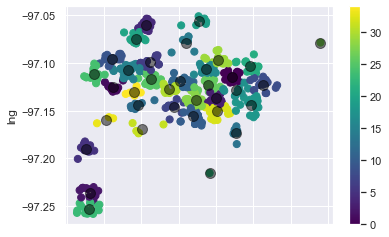

In [ ]:
df.plot.scatter(x = 'lat', y = 'lng', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

I wanted to look at them on a map so I decided to use plotly which has a nice easy interactive mapping tool.

You can see that it does a good job of grouping but the cluster sizes are wildly different. This creates the most well grouped points but we need to use this for delivery with volunteers and the most we would want in a single list would be 20 or so. This also corresponds with a limit of list size of the software I have used to create optimized routes, routexl. 

In [ ]:
import plotly.express as px
fig = px.scatter_mapbox(
                        df2, 
                        lat="lat", 
                        lon="lng", 
                        color="delivery_route", 
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=10, 
                        size="lat", 
                        zoom=10
                       ) 
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Kmeans Constrained

Let's try utilyzing Kmeans Constrained which allows us to set the number of clusters as well as the max size and minimum size of the clusters. I used the same no_of_clusters variable and then dynamically set the max to the desired list size and minimum to be a relatively arbitrary number of -3 as to keep the variance to a minimum.

In [ ]:
kmeans = KMeansConstrained(
    n_clusters=no_of_clusters,
    size_min=desired_list_size - 3,
    size_max=desired_list_size,
    random_state=0)
kmeans.fit(df2[df2.columns[1:3]]) # Compute k-means clustering.
df['delivery_route'] = kmeans.fit_predict(df2[df2.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df2[df2.columns[1:3]]) # Labels of each point
df2.head(10)

,Voter File VANID,lat,lng,delivery_route
0,302815,33.142602,-97.258254,23
1,575048,33.144572,-97.121205,7
2,640440,33.214540,-97.053138,11
3,689001,33.227924,-97.132361,1
4,1025558,33.175101,-97.060067,21
5,1705627,33.170617,-97.131506,30
6,1712651,33.217498,-97.118838,13
7,2075916,33.181524,-97.121579,32
8,2342933,33.142835,-97.241081,2
9,2510307,33.156595,-97.128796,26


Now you can see below that we have the same number of clusters but they are within 12 - 15 addresses per cluster.

In [ ]:
df2.groupby(by=["delivery_route"]).count()

,Voter File VANID,lat,lng
delivery_route,,,
0,15,15,15
1,15,15,15
2,15,15,15
3,15,15,15
4,14,14,14
5,15,15,15
6,15,15,15
7,13,13,13
8,15,15,15


In [ ]:
import plotly.express as px
# px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_mapbox(
                        df2, 
                        lat="lat", 
                        lon="lng", 
                        color="delivery_route", 
                        color_continuous_scale=px.colors.diverging.Portland, 
                        size_max=10, 
                        size="lat", 
                        zoom=10
                       ) 
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
import plotly.express as px
# px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.line_mapbox(
                        df2, 
                        lat="lat", 
                        lon="lng", 
                        color="delivery_route", 
                        color_discrete_sequence=px.colors.diverging.Portland, 
                        # size_max=10, 
                        # size="lat", 
                        zoom=10,
                        line_group="delivery_route",
                        category_orders={'delivery_routes': ['0']}
                       ) 
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

This looks great to me! The final step is to export to csv.

In [ ]:
df2.to_csv('fake_delivery_data_clustered.csv')